<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Training-a-Neural-Network" data-toc-modified-id="1.-Training-a-Neural-Network-1">1. Training a Neural Network</a></span></li><li><span><a href="#2.-Decompose-into-PCA-Components" data-toc-modified-id="2.-Decompose-into-PCA-Components-2">2. Decompose into PCA Components</a></span></li><li><span><a href="#3.-N-best-PCA-Components-and-Plot-N-vs-Testing-Accuracy" data-toc-modified-id="3.-N-best-PCA-Components-and-Plot-N-vs-Testing-Accuracy-3">3. N-best PCA Components and Plot N vs Testing Accuracy</a></span></li><li><span><a href="#4.-100-best-PCA-Components" data-toc-modified-id="4.-100-best-PCA-Components-4">4. 100-best PCA Components</a></span></li><li><span><a href="#5.-Repeat-Step-3." data-toc-modified-id="5.-Repeat-Step-3.-5">5. Repeat Step 3.</a></span></li><li><span><a href="#6.-Repeat-Steps-4.-and-5." data-toc-modified-id="6.-Repeat-Steps-4.-and-5.-6">6. Repeat Steps 4. and 5.</a></span></li><li><span><a href="#Evaluation-and-Conclusion" data-toc-modified-id="Evaluation-and-Conclusion-7">Evaluation and Conclusion</a></span></li></ul></div>

Author: SL

Last Edited: 10.11.2021

Link to this notebook on GitHub: https://github.com/SL023/MLforPhys/blob/main/Week5_PCA_with_MNIST.ipynb


**Task Description**

1. Train a neural network on the MNIST training dataset that achieves acceptable performance on the test dataset (>95% accuracy)
2. Decompose the MNIST training dataset into its PCA components
3. Use the N-best PCA components to make a new testing dataset (using the 10,000 MNIST test images) and make a plot of N vs testing accuracy using the neural network trained in 1) *WITHOUT RETRAINING THE NETWORK*
4. Now using the 100-best PCA components make a new training dataset (using the 60,000 MNIST training images) and retrain your neural network from 1)
5. Repeat step 3 using your new neural network from 4)
6. Finally repeat steps 4 and 5 using a network trained with the best 20 components

In [1]:
# import relevant modules
import matplotlib.pyplot as plt
import numpy as np

# tensorFlow and tf.keras for neural network
import tensorflow as tf
from tensorflow import keras

# linalg for calculating eigenvectors and eigenvalues 
from scipy import linalg

# adjusting style of plots
import matplotlib.style
import matplotlib as mpl 

mpl.rcParams['figure.figsize'] = [4.0, 3.0] 
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200
plt.style.use('bmh')

# pandas for creating summary tables 
import pandas as pd

## 1. Training a Neural Network

Train a neural network on the MNIST training dataset that achieves acceptable performance on the test dataset (>95% accuracy)

For this step, we use the same general code structure and network as Week 4's CNN with MNIST: https://github.com/SL023/MLforPhys/blob/main/Week4_MNIST_CNN.ipynb

In [2]:
# load MNIST data 
mnist = keras.datasets.mnist   
# assign test and training images and labels
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# reshape images for convolutional neural network
train_images = train_images.reshape(-1,28,28,1)
test_images = test_images.reshape(-1,28,28,1)

# normalise RGB pixel values so they are between 0 and 1
train_images=train_images/255.0
test_images=test_images/255.0

In [3]:
# create sequential model
model = keras.Sequential()

# specify layers to add to model
model.add(keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D((3,3)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

In [4]:
# compile model and specify the loss function, optimizer and metrics used in monitoring the training
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [5]:
# summarise the layers, output shape and parameters of the network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [6]:
# fit the model to the provided original MNIST training images with 10 epochs
history = model.fit(train_images, train_labels, batch_size=250, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
240/240 [==============================] - 17s 70ms/step - loss: 0.9012 - accuracy: 0.7022 - val_loss: 0.2164 - val_accuracy: 0.9488
Epoch 2/10
240/240 [==============================] - 16s 67ms/step - loss: 0.4335 - accuracy: 0.8632 - val_loss: 0.1234 - val_accuracy: 0.9658
Epoch 3/10
240/240 [==============================] - 16s 66ms/step - loss: 0.3303 - accuracy: 0.8958 - val_loss: 0.0889 - val_accuracy: 0.9745
Epoch 4/10
240/240 [==============================] - 16s 67ms/step - loss: 0.2834 - accuracy: 0.9117 - val_loss: 0.0741 - val_accuracy: 0.9783
Epoch 5/10
240/240 [==============================] - 16s 66ms/step - loss: 0.2536 - accuracy: 0.9187 - val_loss: 0.0650 - val_accuracy: 0.9803
Epoch 6/10
240/240 [==============================] - 16s 67ms/step - loss: 0.2359 - accuracy: 0.9250 - val_loss: 0.0587 - val_accuracy: 0.9831
Epoch 7/10
240/240 [==============================] - 17s 70ms/step - loss: 0.2215 - accuracy: 0.9286 - val_loss: 0.0550 - val_accuracy:

In [7]:
# output accuracy and loss of model evaluated with MNIST test images 
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.0472 - accuracy: 0.9859


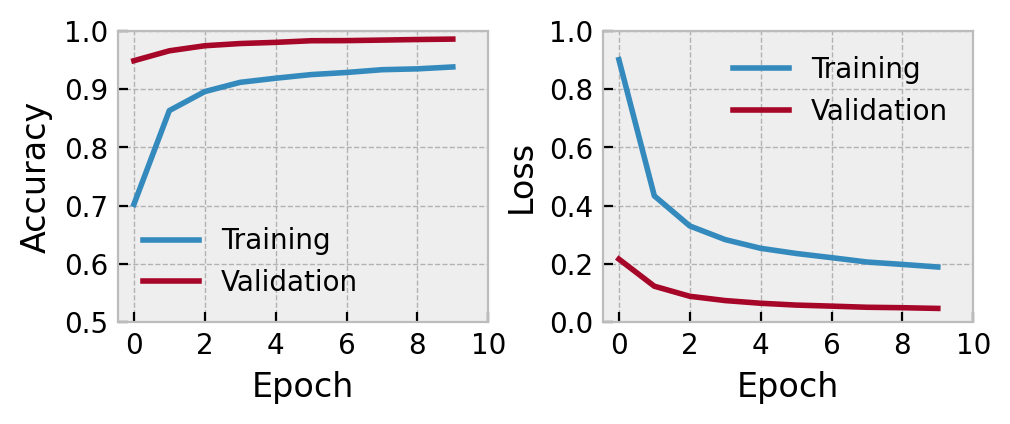

In [8]:
# create new figure with 2 subplots
fig,ax = plt.subplots(1, 2, figsize=(5,2))
# prevent overlap of subplots
plt.tight_layout()

# first subplot to display validation and training accuracy against epochs
ax[0].plot(history.history['accuracy'], label='Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
# axis labels and legend
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
# alter default axis limits and ticks
ax[0].set_ylim([0.5, 1.0])
ax[0].set_xticks([0,2,4,6,8,10])

# second subplot to display validation and training loss against epochs
ax[1].plot(history.history['loss'], label='Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
# axis labels and legend
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
# alter default axis limits and ticks
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xticks([0,2,4,6,8,10]);

We are able to achieve a testing accuracy of 98.59%, thus above the required target. 

## 2. Decompose into PCA Components

Decompose the MNIST training dataset into its PCA components

This step uses the same code structure adapted from the course notebook provided: https://github.com/nichol77/mlForPhysicists/blob/master/Week5/Week5_PCA.ipynb

In [9]:
# reshape training and testing images 
X_train = np.reshape(train_images,(60000,784))
X_test = np.reshape(test_images,(10000,784))
print("X_train.shape:",np.shape(X_train))
print("X_test.shape:",np.shape(X_test))


# calculate mean of training and testing data
mu_train = np.mean(X_train, axis = 0)
mu_test = np.mean(X_test, axis = 0)

x_train = X_train - mu_train
x_test = X_test - mu_test

# calculate covariance matrix 
rho_train = np.cov(x_train,rowvar=False) 
rho_test = np.cov(x_test,rowvar=False) 
print("rho_train.shape:",np.shape(rho_train))
print("rho_test.shape:",np.shape(rho_test))

X_train.shape: (60000, 784)
X_test.shape: (10000, 784)
rho_train.shape: (784, 784)
rho_test.shape: (784, 784)


In [10]:
# obtain eigenvalues and eigenvectors, and use np.flip to reverse to descending order 
vals_train,vecs_train = linalg.eigh(rho_train)
vecs_train = np.flip(vecs_train)
vals_train = np.flip(vals_train)

vals_test,vecs_test = linalg.eigh(rho_test)
vecs_test = np.flip(vecs_test)
vals_test = np.flip(vals_test)

# calculate the dot product between x and the eigenvectors
P_train = np.dot(x_train, vecs_train)
P_test = np.dot(x_test, vecs_test)

## 3. N-best PCA Components and Plot N vs Testing Accuracy

Use the N-best PCA components to make a new testing dataset (using the 10,000 MNIST test images) and make a plot of N vs testing accuracy using the neural network trained in 1) *WITHOUT RETRAINING THE NETWORK*

Here, we define a new function for evaluating the model accuracy of the testing dataset. 

In [11]:
def N_best_PCA_test(N_test):
    '''
    Function to Test the N-best PCA Components on the Testing Images 
    Inputs: 
        N_test: Maximum number of best PCA Components to use for Testing Images 
    Outputs: 
        N_array = Numpy Array of "N" used to test N-best PCA Components
        test_acc_vals = Array of Testing Accuracy corresponding to each value in N_array
    '''
    # initialise empty array for storing testing accuracy values 
    test_acc_vals = []
    # create array in steps of 10 between 0 and N_test
    N_array = np.arange(0, N_test+10, 10)
    # iterate over each value of N in N_array
    for n in N_array: 
        # calculate matrix multiplication over first N columns of P and rows of v^T
        new_image_test = (np.dot(P_test[:,0:n],vecs_test.T[0:n,:]))+mu_test
        # reshape the test images to the original 28 x 28 pixel images 
        new_image_test = np.reshape(new_image_test,(10000, 28,28, 1))
        # evaluate the model on these testing images 
        test_loss, test_acc = model.evaluate(new_image_test,  test_labels, verbose=0)
        # store the testing accuracy in the test_acc_vals array
        test_acc_vals.append(test_acc)
    # return array of N and corresponding testing accuracy
    return N_array, test_acc_vals

In [12]:
# obtain max number of PCA components
N_max = len(vals_test)

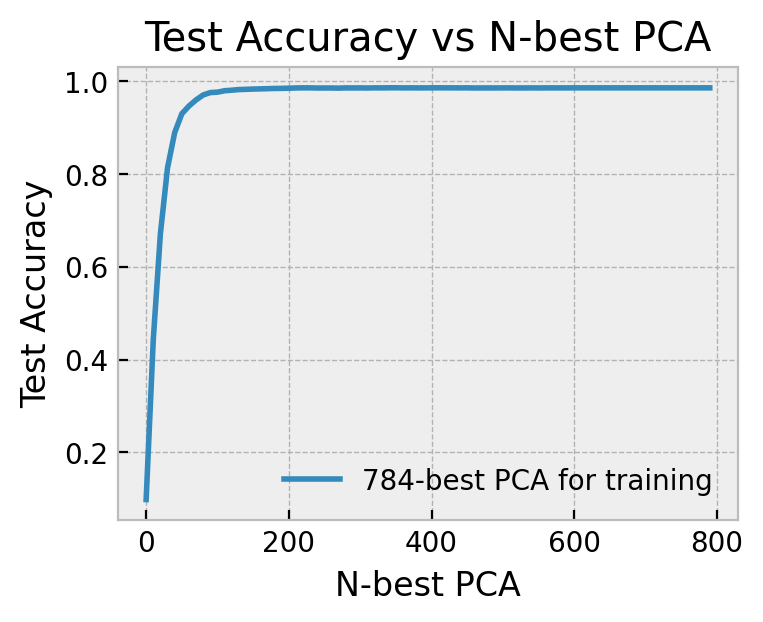

In [13]:
# create a new figure 
fig,ax=plt.subplots()
# evaluate model testing accuracy on fully trained network above
N_array, test_acc_vals = N_best_PCA_test(N_max)
# plot N against test accuracy
ax.plot(N_array, test_acc_vals, label = "{}-best PCA for training".format(N_max))
# add axis labels, title and legend 
ax.set_xlabel("N-best PCA")
ax.set_ylabel("Test Accuracy")
ax.set_title('Test Accuracy vs N-best PCA')
ax.legend();

## 4. 100-best PCA Components 

Now using the 100-best PCA components make a new training dataset (using the 60,000 MNIST training images) and retrain your neural network from 1). 

For the training dataset, we can define a new function to create the same NN structure with varying N-best PCA components used. 

In [14]:
def N_best_PCA_train(N_train):
    '''
    Function to Train the N-best PCA Components
    Inputs: 
        N_train: Number of best PCA Components to use for Training Images 
    Outputs: 
        model: Compiled Model with N-best PCA Components of Training Images
        history: Fitted Model with N-best PCA Components of Training Images
    '''
    # initialise empty array for storing testing accuracy values 
    new_image_train = (np.dot(P_train[:,0:N_train],vecs_train.T[0:N_train,:]))+mu_train
    PCA_train = np.reshape(new_image_train,(60000, 28,28, 1))
    
    # create sequential model
    model = keras.Sequential()

    # specify layers to add to model
    model.add(keras.layers.Conv2D(24, (5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D((3,3)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # compile model and specify the loss function, optimizer and metrics used in monitoring the training
    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
    
    # fit the model 
    history = model.fit(PCA_train, train_labels, batch_size=250, epochs=10, verbose=0)
    
    return model, history

In [15]:
# train NN with 100-best PCA Components
model, history = N_best_PCA_train(100)

## 5. Repeat Step 3.

Repeat step 3 using your new neural network from 4)

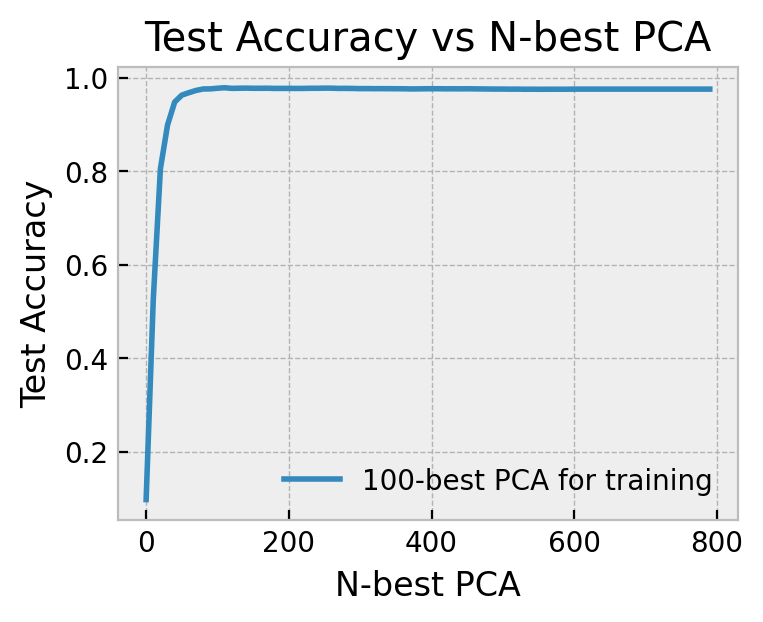

In [16]:
# create a new figure 
fig,ax=plt.subplots()
# evaluate model testing accuracy on fully trained network above
N_array, test_acc_vals = N_best_PCA_test(N_max)
# plot N against test accuracy
ax.plot(N_array, test_acc_vals, label = "{}-best PCA for training".format(100))
# add axis labels, title and legend 
ax.set_xlabel("N-best PCA")
ax.set_ylabel("Test Accuracy")
ax.set_title('Test Accuracy vs N-best PCA');
ax.legend();

## 6. Repeat Steps 4. and 5.

Finally repeat steps 4 and 5 using a network trained with the best 20 components

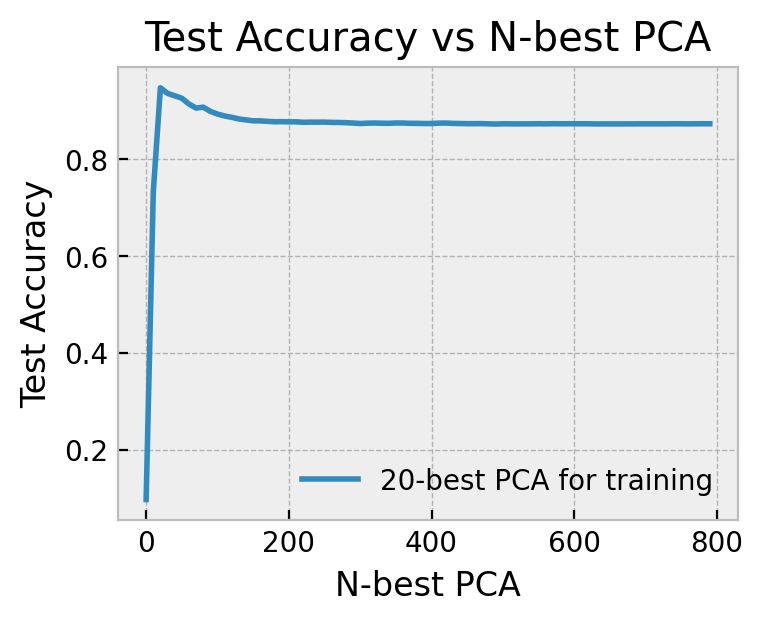

In [17]:
# train NN with 20-best PCA Components
model, history = N_best_PCA_train(20)

# create a new figure 
fig,ax=plt.subplots()
# evaluate model testing accuracy on fully trained network above
N_array, test_acc_vals = N_best_PCA_test(N_max)
# plot N against test accuracy
ax.plot(N_array, test_acc_vals, label = "{}-best PCA for training".format(20))
# add axis labels, title and legend 
ax.set_xlabel("N-best PCA")
ax.set_ylabel("Test Accuracy")
ax.set_title('Test Accuracy vs N-best PCA')
ax.legend();

## Evaluation and Conclusion

We can plot the various N-best PCA Components of the training images on the same figure for easier comparison. 

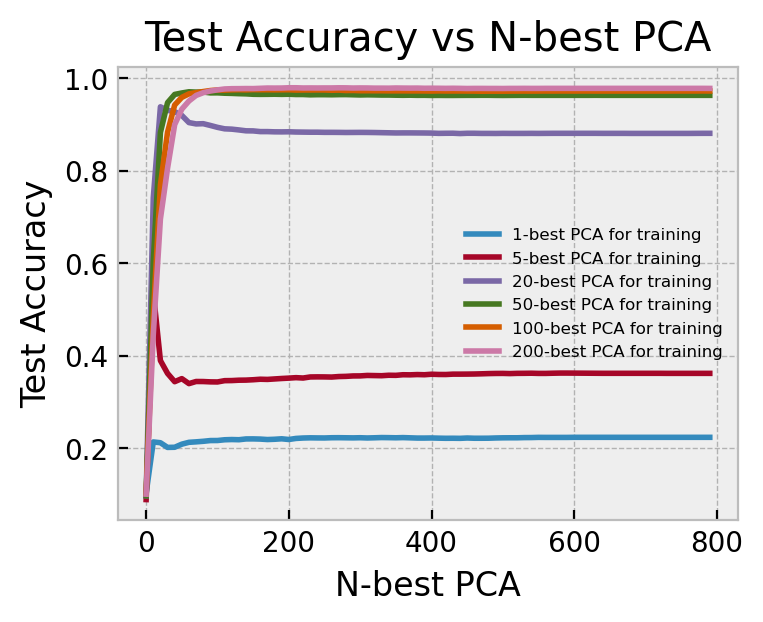

In [21]:
# create a new figure 
fig,ax=plt.subplots()
for i in [1, 5, 20, 50, 100, 200]:
    # train NN with N-best PCA Components
    model, history = N_best_PCA_train(i)
    # evaluate model testing accuracy on fully trained network above
    N_array, test_acc_vals = N_best_PCA_test(N_max)
    # plot N against test accuracy
    ax.plot(N_array, test_acc_vals, label = "{}-best PCA for training".format(i))
    # add axis labels, title and legend 
    ax.set_xlabel("N-best PCA")
    ax.set_ylabel("Test Accuracy")
    ax.set_title('Test Accuracy vs N-best PCA')
    ax.legend(fontsize=6);

The figure above shows how the testing accuracy varies as we change the number of best PCA components used for the training and testing images in the MNIST dataset. 

Evidently we see that as the number of PCA components in the training dataset increases, the overall test accuracy also increases. For 50, 100 and 200-best PCA components, we can see that the test accuracy increases in the range of ~10-30 N-best PCA in the testing dataset until it stabilizes to a maximum value. However, for the case of 1, 5, 20 and 50-best PCA components in the training dataset, we see that the test accuracy increases to a maximum in the same range, but then drops before stabilizing at a lower value. Thus, with less PCA components used in the training model, the reliability of the testing performance has decreased, particularly for testing with small N-best PCA components. 